In [1]:
using EchoStateNetworks
using Gadfly
import DataFrames

    +(AbstractArray, DataArrays.DataArray) at /home2/minemoto/.julia/v0.4/DataArrays/src/operators.jl:276
is ambiguous with: 
    +(WoodburyMatrices.SymWoodbury, AbstractArray{T<:Any, 2}) at /home2/minemoto/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:107.
To fix, define 
    +(WoodburyMatrices.SymWoodbury, DataArrays.DataArray{T<:Any, 2})
before the new definition.
    +(AbstractArray, DataArrays.AbstractDataArray) at /home2/minemoto/.julia/v0.4/DataArrays/src/operators.jl:300
is ambiguous with: 
    +(WoodburyMatrices.SymWoodbury, AbstractArray{T<:Any, 2}) at /home2/minemoto/.julia/v0.4/WoodburyMatrices/src/SymWoodburyMatrices.jl:107.
To fix, define 
    +(WoodburyMatrices.SymWoodbury, DataArrays.AbstractDataArray{T<:Any, 2})
before the new definition.


In [2]:
T = Float64

test_range = 1:2000
train_range = 1:500

# training data
input_train(n) = (n%200)<100?0.1:0.6
x_train = T[input_train(n) for n in 0:length(train_range)-1]
x_train = reshape(x_train,1,length(x_train))

target_train(n) = (n%200)<100?0.5sin(pi*n/10):0.5sin(pi*n/50)
y_train = T[target_train(n) for n in 0:length(train_range)-1]
y_train = reshape(y_train,1,length(y_train))

# test data
input_test(n) = n<200||(n>780&&n<1703)?0.10:0.60
x_test = T[input_test(n) for n in 0:length(test_range)-1]
x_test = reshape(x_test,1,length(x_test))

target_test(n) = n<200||(n>780&&n<1703)?0.5sin(pi*n/10):0.5sin(pi*n/50)
y_test = T[target_test(n) for n in 0:length(test_range)-1]
y_test = reshape(y_test,1,length(y_test))


1x2000 Array{Float64,2}:
 0.0  0.154508  0.293893  0.404508  …  -0.0936907  -0.0626666  -0.0313953

train RMSE: 0.007664842647482037


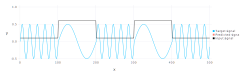

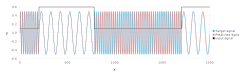

test RMSE:  0.21514423958187898


In [3]:
esn = EchoStateNetwork{T}(Ni=1, No=1, Nr=400, sparsity=0.99, noise_level=0.2,
                          spectral_radius=1.1, teacher_forcing=true, leaking_rate=0.99, rng=MersenneTwister(0x59))

states = EchoStateNetworks.reservoir_states(esn, x_train, y_train)

y_pred = train!(esn, x_train, y_train, reg=1.0e-8, discard=100)
println("train RMSE: $(norm(y_train-y_pred)/sqrt(length(train_range)))")
    
y_pred = predict!(esn, x_test, cont=true)
println("test RMSE:  $(norm(y_test-y_pred)/sqrt(length(test_range)))")

draw(SVG(24cm, 8cm), plot(
layer(x=train_range, y=x_train, Geom.line, Theme(default_color=colorant"black")),
layer(x=train_range, y=y_train, Geom.line),
Guide.manual_color_key("", ["Target signal", "Predicted signal", "Input signal"], ["deepskyblue", "salmon", "black"])
))
draw(SVG(24cm, 8cm), plot(
layer(x=test_range, y=y_pred, Geom.line, Theme(default_color=colorant"salmon")), 
layer(x=test_range, y=x_test, Geom.line, Theme(default_color=colorant"black")),
layer(x=test_range, y=y_test, Geom.line),
Guide.manual_color_key("", ["Target signal", "Predicted signal", "Input signal"], ["deepskyblue", "salmon", "black"])
))